# Preprocessing

In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
import tldextract
from urllib.parse import urlparse

In [4]:
df = pd.read_csv('phishing_site_urls.csv')

In [5]:
df.isnull().values.any()

False

In [6]:
df.columns = [x.lower() for x in df.columns]
df.head()

,url,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [7]:
df['label'].value_counts()

good    392924
bad     156422
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

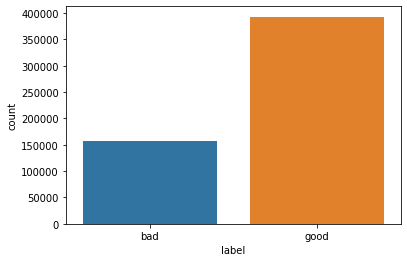

In [8]:
sns.countplot(x="label",data=df)

In [9]:
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)

In [10]:
def url_process(url):
    url = re.sub('[^a-zA-Z\ \n]', '.', url.lower())
    url =  re.sub('\.{1,}', ' ', url)
    url = url.split(' ')
    
    stemmer = SnowballStemmer("english")
    url = [stemmer.stem(word) for word in url]
    url = ' '.join(url)
    return url

In [11]:
df['url_clean'] = df['url'].apply(url_process)

In [12]:
df.head()

,url,label,Y,url_clean
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,1,nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,1,www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,1,serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,1,mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,1,thewhiskeydreg com wp content theme widescreen...


# Feature extraction using CountVectorizer

In [13]:
cv=CountVectorizer(ngram_range=(1, 2))

X_train, X_test, y_train, y_test = train_test_split(df['url_clean'], df['Y'], test_size=0.2, random_state=5555)

cv_fit = cv.fit(X_train)
X_train = cv_fit.transform(X_train)

X_test = cv_fit.transform(X_test)

#  Support Vector Machine Model

### Base Model

In [14]:
from sklearn.svm import LinearSVC

svc_base = LinearSVC()

svc_base.fit(X_train,y_train)
y_pred_svc_base = svc_base.predict(X_test)
print(classification_report(y_test,y_pred_svc_base))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     78641
           1       0.98      0.96      0.97     31229

    accuracy                           0.98    109870
   macro avg       0.98      0.97      0.98    109870
weighted avg       0.98      0.98      0.98    109870



C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
from sklearn.svm import LinearSVC

svc_cls = LinearSVC()

##Using gridsearch parameters
parameters = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [16]:
%%time
gridsearch_cls = GridSearchCV(estimator=svc_cls, param_grid=parameters, verbose = 3)
gridsearch_cls.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=1e-05;, score=0.786 total time=   1.8s
[CV 2/5] END ...........................C=1e-05;, score=0.786 total time=   1.8s
[CV 3/5] END ...........................C=1e-05;, score=0.786 total time=   1.8s
[CV 4/5] END ...........................C=1e-05;, score=0.784 total time=   1.8s
[CV 5/5] END ...........................C=1e-05;, score=0.786 total time=   1.9s
[CV 1/5] END ..........................C=0.0001;, score=0.858 total time=   1.8s
[CV 2/5] END ..........................C=0.0001;, score=0.858 total time=   1.7s
[CV 3/5] END ..........................C=0.0001;, score=0.858 total time=   1.7s
[CV 4/5] END ..........................C=0.0001;, score=0.855 total time=   1.7s
[CV 5/5] END ..........................C=0.0001;, score=0.857 total time=   1.7s
[CV 1/5] END ...........................C=0.001;, score=0.922 total time=   1.4s
[CV 2/5] END ...........................C=0.001;,

C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ...............................C=1;, score=0.979 total time=  32.0s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ...............................C=1;, score=0.978 total time=  31.8s
[CV 3/5] END ...............................C=1;, score=0.979 total time=  23.4s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ...............................C=1;, score=0.978 total time=  30.9s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ...............................C=1;, score=0.980 total time=  31.6s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..............................C=10;, score=0.979 total time=  32.6s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..............................C=10;, score=0.977 total time=  33.8s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..............................C=10;, score=0.978 total time=  34.4s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..............................C=10;, score=0.978 total time=  34.0s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..............................C=10;, score=0.979 total time=  33.2s
CPU times: total: 7min 35s
Wall time: 7min 43s


C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             verbose=3)

In [17]:
print('Best score:', gridsearch_cls.best_score_)
print('Best parameters: ', gridsearch_cls.best_params_)

Best score: 0.9788202309103798
Best parameters:  {'C': 1}


In [18]:
%%time
##Selecting the best params
from sklearn import metrics
svc_cls_best = LinearSVC(C=gridsearch_cls.best_params_['C'])

CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
svc_cls_best.fit(X_train, y_train)
y_pred_svc = svc_cls_best.predict(X_test)
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     78641
           1       0.98      0.96      0.97     31229

    accuracy                           0.98    109870
   macro avg       0.98      0.97      0.98    109870
weighted avg       0.98      0.98      0.98    109870



C:\Users\hengg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     79147
           1       0.96      0.98      0.97     30723

    accuracy                           0.98    109870
   macro avg       0.97      0.98      0.98    109870
weighted avg       0.98      0.98      0.98    109870


CONFUSION MATRIX


<AxesSubplot:>

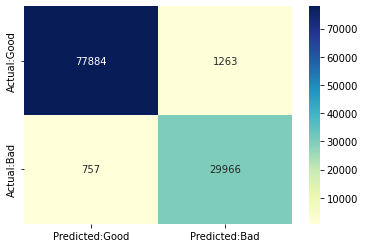

In [23]:
con_mat = pd.DataFrame(confusion_matrix(svc_cls_best.predict(X_test), y_test),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(svc_cls_best.predict(X_test), y_test))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")